In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pathlib

from common import loss_utils

import sys
sys.path.append('./dgmr_original')
import dgmr

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [4]:
FORECAST = 24
INPUT_STEPS = 4
BATCH_SIZE = 16

In [5]:
p = pathlib.Path('data/train.npz')
f = np.load(p)
times = f['times']
data = f['data']

In [6]:
times.shape, data.shape

((41896,), (41896, 325, 400))

In [7]:
torch.manual_seed(7)
tsfm = transforms.Compose([
    transforms.Normalize(240.3414, 146.52366),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
#     transforms.ColorJitter(brightness=0.5, contrast=0.5),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # can shift up/down by 128*0.1 = 12.8 pixels
])

In [8]:
def check_times(tstart, tend):
    return int((tend - tstart) / np.timedelta64(1, 'm')) == 175

class CustomTensorDataset(torch.utils.data.Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, times, data, tsfm, random_state=7):
        self.times = times
        self.data = data
        self.tsfm = tsfm
        self.generator = np.random.RandomState(random_state)
        
        
    def _get_crop(self, data):
        # roughly over the mainland UK
        rand_x = self.generator.randint(0, data.shape[2] - 128)
        rand_y = self.generator.randint(0, data.shape[1] - 128)
        # make a data selection
        return data[:, rand_y : rand_y + 128, rand_x : rand_x + 128]

    def __getitem__(self, index):
        tend = self.times[index + 35]
        tstart = self.times[index]
        if not check_times(tstart, tend):
            return self.__getitem__((index + 35) % len(self))
        all_data = self.data[index:index+INPUT_STEPS+24]
        all_data = self._get_crop(all_data)
#         -1 means rotate cw 90, 0 means no rotation, 1 means ccw 90, 2 means ccw 180
        rot_amount = self.generator.randint(-1, 3)
        if rot_amount != 0:
            all_data = np.rot90(all_data, k=rot_amount, axes=(1, 2)).copy()
#         generate contrast and brightness changes
        cf = np.random.uniform(low=0.7, high=1.3)
        bf = np.random.uniform(low=-50, high=50)
        all_data = all_data * cf + bf
        all_data = torch.FloatTensor(all_data)
        all_data = self.tsfm(all_data)
        x = all_data[:INPUT_STEPS]
        y = all_data[INPUT_STEPS:]
        return x, y

    def __len__(self):
        return len(self.times) - 35

ds = CustomTensorDataset(times, data, tsfm)
dl = torch.utils.data.DataLoader(
    ds,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=2,
    prefetch_factor=4
)


In [9]:
x, y = ds[0]

In [10]:
x.shape, y.shape

(torch.Size([4, 128, 128]), torch.Size([24, 128, 128]))

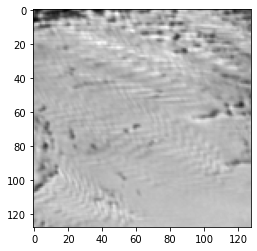

In [11]:
plt.imshow(x[-1], cmap='gray')

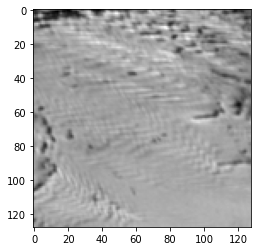

In [12]:
plt.imshow(y[0], cmap='gray')

In [13]:
ccs = dgmr.common.ContextConditioningStack(
    input_channels=1,
    conv_type='standard',
    output_channels=192,
)

lcs = dgmr.common.LatentConditioningStack(
    shape=(8 * 1, 128 // 32, 128 // 32),
    output_channels=384,
)

sampler = dgmr.generators.Sampler(
    forecast_steps=FORECAST,
    latent_channels=384,
    context_channels=192,
)

model = dgmr.generators.Generator(ccs, lcs, sampler)
model = model.to(DEVICE)


# model = dgmr.DGMR(
#     forecast_steps=FORECAST,
#     input_channels=1,
#     output_shape=128,
#     latent_channels=384,
#     context_channels=192,
#     num_samples=3,
# )
model.load_state_dict(torch.load('weights/dgmr_128_msssim_wd/dgmr_epochs=5_batch=899_loss=0.3903.pt'))
model = model.to(DEVICE)


In [ ]:
# model = model.generator

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model)} trainable parameters')

The model has 13399657 trainable parameters


In [15]:
class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_t, y_prime_t):
        ey_t = y_t - y_prime_t
        return torch.mean(torch.log(torch.cosh(ey_t + 1e-12)))

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
lcl_criterion = LogCoshLoss()

In [18]:
def train_epoch(model, epoch, dl, optimizer, criterion):
    model.train()

    epoch_loss = 0
    total_count = 0
    optimizer.zero_grad()
    pbar = tqdm.tqdm(dl)
    for i, (srcs, trgs) in enumerate(pbar):
        x = srcs.float().to(DEVICE)
        y = trgs.float().to(DEVICE)
        # add a dimension because 1D image
        x = torch.unsqueeze(x, dim=2)
        y = torch.unsqueeze(y, dim=2)
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        ls = loss.item()
        epoch_loss += ls
        total_count += 1
        if i % 1 == 0:
            ls = round(ls, 4)
            avg_loss = round(epoch_loss / total_count, 4)
            pbar.set_description(f'Avg Loss, Batch Loss: {avg_loss, ls}')
            if i % 300 == 299:
                torch.save(model.state_dict(), f'weights/dgmr_128_wd/dgmr_epochs={epoch}_batch={i}_loss={avg_loss}.pt')

    return epoch_loss / total_count




In [19]:
EPOCHS = 100
EXISTING = 4

for i in range(EXISTING + 1, EPOCHS + 1):
    print(f"Epoch {i}")
    avg_loss = train_epoch(model, i, dl, optimizer, lcl_criterion)
    avg_loss = round(avg_loss, 4)
    torch.save(model.state_dict(), f'weights/dgmr_128_wd/dgmr_epochs={i}_loss={avg_loss}.pt')


Epoch 5


  0%|          | 0/2617 [00:00<?, ?it/s]/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Avg Loss, Batch Loss: (0.0856, 0.0931): 100%|██████████| 2617/2617 [34:34<00:00,  1.26it/s]


Epoch 6


Avg Loss, Batch Loss: (0.085, 0.1001): 100%|██████████| 2617/2617 [34:49<00:00,  1.25it/s] 


Epoch 7


Avg Loss, Batch Loss: (0.0844, 0.1459): 100%|██████████| 2617/2617 [34:51<00:00,  1.25it/s]


Epoch 8


Avg Loss, Batch Loss: (0.0841, 0.1116): 100%|██████████| 2617/2617 [34:45<00:00,  1.25it/s]


Epoch 9


Avg Loss, Batch Loss: (0.0844, 0.0759):   9%|▉         | 244/2617 [03:14<31:39,  1.25it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Avg Loss, Batch Loss: (0.0833, 0.1231):  79%|███████▉  | 2076/2617 [27:36<07:11,  1.25it/s]


KeyboardInterrupt: 

In [28]:
torch.save(model.state_dict(), f'weights/dgmr_128_wd/tmp.pt')

In [16]:
def get_mssim(y, x, average=True):
    assert len(y.shape) == 5
    if average:
        criterion = loss_utils.MS_SSIM(data_range=1023.0, size_average=True, win_size=3, channel=y.shape[1])
        return criterion(y, x)
    else:
        scores = []
        criterion = loss_utils.MS_SSIM(data_range=1023.0, size_average=True, win_size=3, channel=1)
        for i in range(y.shape[1]):
            score = criterion(y[:,i:i+1], x[:,i:i+1])
            scores.append(score.item())
        return scores

In [17]:
LOOKS = int(2000/BATCH_SIZE)

In [18]:
_MEAN_PIXEL = 240.3414
_STD_PIXEL = 146.52366


In [19]:
model.train()
criterion = loss_utils.MS_SSIM(
    data_range=1023.0, size_average=True, win_size=3, channel=24)

scores = []
running_total = 0
running_count = 0
pbar = tqdm.tqdm(dl, total=LOOKS)
for i, (srcs, trgs) in enumerate(pbar):
    if i > LOOKS:
        break
    x = srcs.to(DEVICE)
    y = trgs.to(DEVICE)
    # add a dimension because 1D image
    x = torch.unsqueeze(x, dim=2)
    y = torch.unsqueeze(y, dim=2)
    
    preds = []
    for _ in range(1):
        with torch.no_grad():
            p = model(x)
            preds.append(p)
    preds = torch.mean(torch.stack(preds, dim=0), dim=0)
    
    y = y * _STD_PIXEL + _MEAN_PIXEL
    preds = preds * _STD_PIXEL + _MEAN_PIXEL
    score = get_mssim(preds, y, average=False)
    scores.append(score)
    
    running_total += np.mean(score)
    running_count += 1
    
    pbar.set_description(f'Avg Score: {running_total/running_count}')

    

  0%|          | 0/125 [00:00<?, ?it/s]/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Avg Score: 0.7282621077365345:  12%|█▏        | 15/125 [00:07<00:55,  1.98it/s]


KeyboardInterrupt: 

In [26]:
scores = np.array(scores)
scores.mean()

0.7349539983170058

In [27]:
step_dgmr = scores.mean(axis=0)
step_dgmr

array([0.89796851, 0.8554463 , 0.82396444, 0.80039698, 0.78148853,
       0.76594306, 0.75310597, 0.74236637, 0.73351121, 0.72586575,
       0.71933912, 0.71363477, 0.70869763, 0.70459603, 0.70105134,
       0.69806042, 0.69530085, 0.69297049, 0.69108092, 0.68912609,
       0.68779105, 0.68638675, 0.68559704, 0.68520632])

In [27]:
step_dgmr = scores.mean(axis=0)
step_dgmr

array([0.89069091, 0.84119753, 0.80510727, 0.77948288, 0.76014342,
       0.74483631, 0.73236842, 0.72197179, 0.71318338, 0.70587086,
       0.69958136, 0.69414143, 0.68945613, 0.68549763, 0.68195219,
       0.67877745, 0.67592991, 0.67367307, 0.67176339, 0.67011384,
       0.66879379, 0.66786701, 0.66729097, 0.66681445])

In [ ]:
step = np.array([0.94732114, 0.8874218 , 0.8358762 , 0.79312605, 0.75684718,
       0.7254723 , 0.71111752, 0.69969728, 0.68989919, 0.68185381,
       0.67520599, 0.66936791, 0.66448703, 0.66054242, 0.65703949,
       0.65408842, 0.65171868, 0.6504889 , 0.64866001, 0.64693765,
       0.64587313, 0.6450839 , 0.64387597, 0.64268631])

In [ ]:
choice = 5
np.array(step[:choice].tolist() + step_dgmr[choice:].tolist()).mean()

0.7278024662812251

In [28]:
out = preds.detach().cpu().numpy()
true = y.detach().cpu().numpy()

out = np.squeeze(out)
true = np.squeeze(true)

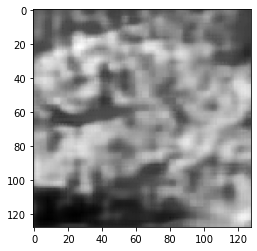

In [29]:
plt.imshow(out[0,0], cmap='gray')

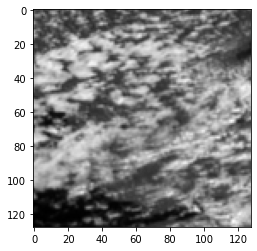

In [30]:
plt.imshow(true[0,0], cmap='gray')

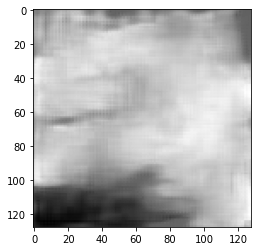

In [31]:
plt.imshow(out[0,-1], cmap='gray')

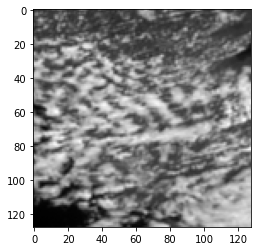

In [32]:
plt.imshow(true[0,-1], cmap='gray')